# Contarinia nasturtii on cabbage models
We will implement atleast one model explained in the `état de l'art` of the contarinia nasturtii (cécidomyie du chou).

The model name is the "Contapré" european model. The second goal in case "Contapré" is not successful is to try to implement the model "MidgEmerge".

**Note: No data at the moment, so hard to try the model. It needs improvements.**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read excel or csv, sort data by date
df = pd.read_excel("data_hammerli.xls", engine='xlrd')

df.sort_values(by=["date"], inplace=True)

plt.rcParams['figure.figsize'] = [15,10]

# Show columns
print("Number of element (hours): ", df["date"].size, "\nColumns: ", df.columns)

Number of element (hours):  2183 
Columns:  Index(['date', 'drybulb_temp_celsius_avg', 'drybulb_temp_celsius_max',
       'drybulb_temp_celsius_min', 'dew_point_celsius_avg',
       'dew_point_celsius_min', 'vpd_kpa_avg', 'vpd_kpa_min',
       'percent_humidity_avg', 'percent_humidity_max', 'percent_humidity_min',
       'precipitation_mm', 'leaf_wetness_min', 'solar_panel_mv_last',
       'battery_mv_last', 'deltat_celsius_avg', 'deltat_celsius_max',
       'deltat_celsius_min'],
      dtype='object')


## Contapré model
The accumulation of DD in the Contapré model (Bouma, 1996) begins when the daily maximum soil temperature at 5cm depth exceeds 20 °C and ≥11 mm of rain follows within 3 days (M Vlaswinkel, pers. comm.). First flight of swede midge was predicted to occur when thermal accumulations(C) exceeded that required for necessary insect development to occur, and was described by the following equation of the Contapré model:

C = $\sum_{t} (T_t - T_0)$

where t = time (days), T = mean daily temperature at soil depth of 5 cm (°C), and T0 = base threshold of development (7.2 °C). C is calculated daily and summed to the previous day’s value. When C reaches 160 DD, adult emergence should occur. Successive flights occur when C again reaches 160 DD. In addition, if the mean daily temperature over 2 days falls below 15 °C, flight is delayed until the mean daily temperature rises above this value; and, if more than 25 mm of precipitation falls between 135–160 DD, adult flight will occur immediately (M Vlaswinkel, pers. comm.). 


**Questions:**
- When do we reset the C ?

**Notes:**
- To be tested, we don't have any data at the moment

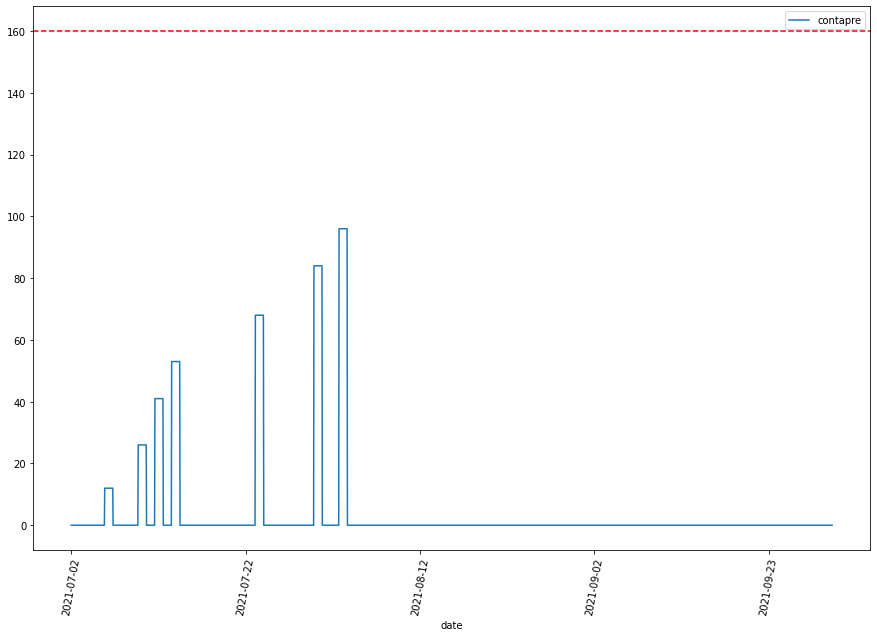

In [19]:
def check_precipitation(df, i):
    mm = 0.0
    for j in range(1, 4):
        mm += df.at[i+j, 'precipitation_mm']
    if mm >= 1: # 11 normally
        return True
    return False


def contapre(df):
    df['contapre'] = 0  # add column for our results

    n = 0
    total_dt = 0.0  # avg temp of the day
    above20 = False
    t0 = 7.2
    c = 0 # never reset ?

    for i, row in df.iterrows():

        n += 1
        total_dt += row['drybulb_temp_celsius_avg']
        above20 = above20 or row['drybulb_temp_celsius_avg'] > 20

        # if end of the day
        if (row['date'].endswith('23:00:00') or row['date'].endswith('23:00')) and above20 and check_precipitation(df, i):
            c += total_dt / n - t0
            df.at[i, 'contapre'] = c
            df.loc[df['date'].str.startswith(row['date'].split(' ')[0]), [
                'contapre']] = df.at[i, 'contapre']  # update all rows of the day

            # prepare next day
            n = 0
            total_dt = 0
            above20 = False


contapre(df)  # call model for df

# Display results
plot = df.plot(x="date", y="contapre", rot=80)
xdate = [item.get_text()[:10]
         for item in plot.get_xticklabels()]
_ = plot.set_xticklabels(xdate)
# there is risk of insects above the red line
_ = plt.axhline(160, color='red', linestyle='--')


# MidgEmerge

Model explained in [one of the annex of the état de l'art](https://atrium.lib.uoguelph.ca/xmlui/bitstream/handle/10214/2488/7287844341381563653.pdf;sequence=1).

Doesn't really give a lot about the model parameter, it explains how to detect each part of the insect development (egg, larva, pupal, adult) and what to look for (temperature, ...) but I think there is missing some information to be able to replicate their model.

It's still possible to give it a try, but it's probably best to first test the Contapré model with some data and to compare the model results with the observation on the field.